# Basic implementation and illustration of the Lanczos algorithm, and its numerical instability

Tutorial and Python codes by Fabien Alet (alet@irsamc.ups-tlse.fr) and Nicolas Macé (mace@irsamc.ups-tlse.fr)

In [1]:
import scipy.sparse as sparse 
import numpy as np 
import scipy.sparse.linalg as la
from scipy.linalg import eigh,norm
import matplotlib.pyplot as plt

from quspin.operators import quantum_operator # Hamiltonian
from quspin.basis import spin_basis_1d # Hilbert space spin basis

### Uncomment if you run into OpenMP issues
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

# First definitions and reference computations

We use the random-field XXZ model for illustration, We use the library `quspin` to code the Hamiltonian to simplify the Notebook, but it is irrelevant for the discussion.

In [2]:
def Hamiltonian(L, Delta, h):
    """
    Construct the Hamiltonian of the system in the zero magnetization sector
    using the quspin library.
    
    Return: the Hamiltonian as a sparse matrix.
    """
    Jxy = 1.0 # xy interaction
    basis = spin_basis_1d(L, pauli=0, Nup=L//2) # zero magnetisation sector
    # define operators with OBC using site-coupling lists
    J_zz = [[Delta, i, i+1] for i in range(L-1)] # OBC
    J_pm = [[Jxy/2.0, i, i+1] for i in range(L-1)] # OBC
    # list of the couplings of H0
    operator_list_0 = [["+-",J_pm],["-+",J_pm],["zz",J_zz]]
    # create operator dictionary for quantum_operator class
    operator_dict = dict(H0=operator_list_0)
    # external fields
    for i in range(L):
        cur_h = np.random.uniform(-h, h)
        operator_dict["z"+str(i)] = [["z", [[cur_h, i]]]]
    # setting up operator
    H_op = quantum_operator(operator_dict, basis=basis, dtype=np.float64)
    return H_op.tocsr()

Now we study a small random field Heisenberg chain.

In [3]:
L = 12
Delta = 1.0
h = 3.0
np.random.seed(31415)
H = Hamiltonian(L=L, Delta=Delta, h=h)

Hermiticity check passed!
Particle conservation check passed!


<ipython-input-2-7ed24b91f332>:22: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  H_op = quantum_operator(operator_dict, basis=basis, dtype=np.float64)


Finally we compute exactly by brute force (using scipy's routines) the lowest-lying eigenvalues, as a reference to test our own Lanczos function

In [4]:
e8 = la.eigsh(H,k=8,which='SA',return_eigenvectors=False)
print ("The last 8 eigenvalues=",e8)

The last 8 eigenvalues= [-5.70229033 -5.87724116 -6.08442644 -6.14620192 -6.25869347 -6.32882778
 -6.54862817 -7.19956053]


# Lanczos routine

Next we define the Lanczos algorithm. Note how easy it is to code it (the notations are the same than in the lecture notes).
This routine outputs the triadiagonal matrix $T$.
Here we save *all* the Lanzcos vectors for illustration of the numerical instability, but in general one should only store the 3 vectors. 
There is a reorthogonalize flag, which picks the routine that does the re-orthogonalization at every step (this is very demanding, but again this is just for illustration).

In [5]:
def lanczos_all(H,steps,v0,reorthogonalize):
    # H Hamiltonian (real)
    # steps Number of Lanczos steps
    # v0: input initial vector (in a matrix form)
    # V: matrix containing *all* Lanczos vectors (steps*size(H))
    V = np.matrix( v0/norm(v0) )
    alpha =  np.zeros(steps) 
    beta =  np.zeros(steps+1)
    for k in range(steps):
        vt = H * V[ :, k]
        if k > 0: vt -= beta[k] * V[:, k-1]
        alpha[k] = (V[:, k].T * vt )[0, 0]

        vt -= alpha[k] * V[:, k]
        beta[k+1] = np.linalg.norm(vt)
        # re-orthogonalization
        if (reorthogonalize==1):
            h1 = V.H*vt
            vt -= V*h1
        V =  np.hstack( (V, vt.copy() / beta[k+1] ) ) 
    rbeta = beta[1:-1]    
    # output tridiagonal matrix (size step*step) 
    return np.diag(alpha) + np.diag(rbeta, 1) + np.diag(rbeta, -1)

Now we illustrate how the Lanczos method converges, and can have numerical instabilities if some eigenstates are converged and the number of Lanczos steps is too large. We loop over several values of $m$ (the size of the Krylov space), just to illustrate. 

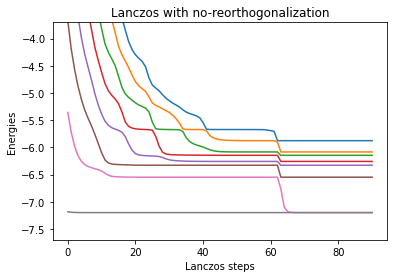

In [6]:
lanczos_energies=[]
v = np.random.rand(H.shape[0])
v0 = np.matrix(v).T

reorthogonalize=0
# don't do this loop in a normal Lanczos calculation, just pick a large enough m!
for m in range(9,100): 
    T=lanczos_all(H,m,v0,reorthogonalize)
    #print (Htilde)
    l0 = la.eigsh(T,8,which='SA',return_eigenvectors=False)
    lanczos_energies.append(l0)

plt.plot(lanczos_energies)
plt.ylim((min(e8)-0.5, max(e8)+2))

plt.title("Lanczos with no-reorthogonalization")
plt.xlabel("Lanczos steps")
plt.ylabel("Energies")

plt.show()

Now ask yourself: which energies are correct? What about degeneracies? To make sure, let's replot the same things and display the correct ones (obtained independently) as dashed lines.

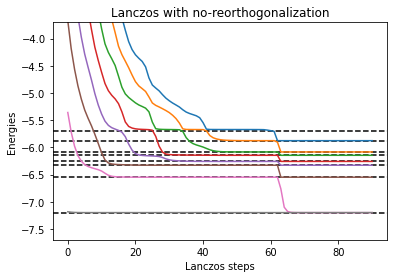

In [7]:
for r in range(8):
    plt.axhline(e8[r],0,100,ls='--',color='k')
plt.plot(lanczos_energies)
plt.ylim((min(e8)-0.5, max(e8)+2))

plt.title("Lanczos with no-reorthogonalization")
plt.xlabel("Lanczos steps")
plt.ylabel("Energies")

plt.show()

We see that at some point, due to some numerical round-off, the excited states pick up a component in another eigenstate direction (the matrix $V$ is no longer stricly orthogonal), and the Lanczos algorithm makes them converges to a lower eigenvalue, as if there were degeneracies in the spectrum. This is called the **ghost problem** (fake degeneracy). Note that the disordered model we considered has no degeneracies (due to the random field, this can be checked with the true eigenvalues displayed above), hence we are sure the ghosts are here.
The ghost problem is readily solved by re-orthogonalization at each step as we see now.

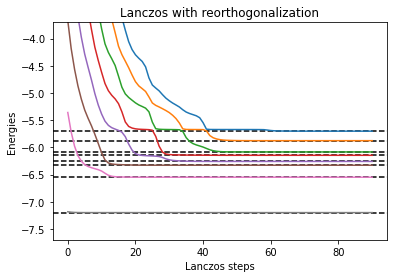

In [9]:
lanczos_energies_r=[]
reorthogonalize=1
for m in range(9,100): 
    T=lanczos_all(H,m,v0,reorthogonalize)
    l0 = la.eigsh(T,8,which='SA',return_eigenvectors=False)
    lanczos_energies_r.append(l0)
    
for r in range(8):
    plt.axhline(e8[r],0,100,ls='--',color='k')
plt.plot(lanczos_energies_r)

plt.ylim((min(e8)-0.5, max(e8)+2))

plt.title("Lanczos with reorthogonalization")
plt.xlabel("Lanczos steps")
plt.ylabel("Energies")

plt.show()

Clearly we are now free of ghosts. But of course the re-orthogonalization is quite demanding, and will be a bottleneck for larger scale simulations. There are fortunately more advanced schemes (implicit restart for instance) which can take care of this issue.